In [1]:
%pip install mesa numpy pandas scipy matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/unicornhappy/.pyenv/versions/3.12.4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


t= 200 bb/ba/sp= 101.9 102.30000000000001 0.4000000000000057 depth= 43.0 42.0 trades_step= 1
t= 200 bb/ba/sp= 99.60000000000001 99.9 0.29999999999999716 depth= 15.0 31.0 trades_step= 19
t= 200 bb/ba/sp= 75.0 75.3 0.29999999999999716 depth= 30.0 14.0 trades_step= 23
t= 200 bb/ba/sp= 107.2 107.60000000000001 0.4000000000000057 depth= 41.0 36.0 trades_step= 3
t= 200 bb/ba/sp= 107.30000000000001 107.5 0.19999999999998863 depth= 14.0 40.0 trades_step= 0
t= 200 bb/ba/sp= 109.7 109.80000000000001 0.10000000000000853 depth= 15.0 1.0 trades_step= 17
t= 200 bb/ba/sp= 87.80000000000001 88.60000000000001 0.7999999999999972 depth= 7.0 13.0 trades_step= 19
t= 200 bb/ba/sp= 103.4 103.7 0.29999999999999716 depth= 14.0 30.0 trades_step= 26
t= 200 bb/ba/sp= 101.80000000000001 102.2 0.3999999999999915 depth= 47.0 45.0 trades_step= 0
t= 200 bb/ba/sp= 94.9 95.30000000000001 0.4000000000000057 depth= 44.0 45.0 trades_step= 8
t= 200 bb/ba/sp= 101.0 101.4 0.4000000000000057 depth= 43.0 45.0 trades_step= 1
t= 

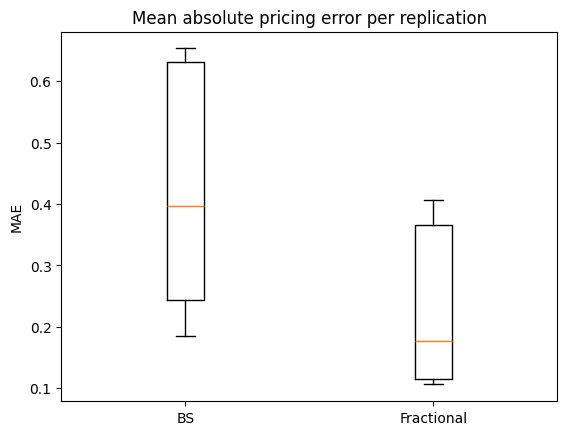

{'option_type': 'put',
 'alpha_frac': 0.5,
 'mean_abs_err_bs': 0.4237052645662918,
 'mean_abs_err_frac': 0.23283665936744588,
 'paired_ttest_t': 7.289288877890631,
 'paired_ttest_p': 4.6172966227794936e-05,
 'wilcoxon_stat': 0.0,
 'wilcoxon_p': 0.001953125,
 'ks_stat': 0.28,
 'ks_p': 0.039194586195352224,
 'n_rep': 10,
 'n_paths': 200,
 'n_mc': 40000}

In [1]:
from analysis import run_h1_pricing_experiment
from visualization import plot_error_box
from analysis import run_abm_paths, estimate_sigma
import numpy as np


cfg = dict(
    S0=100.0,
    dt=1/252,
    steps=252,
    n_fund=50,
    n_noise=50,
    n_chart=50,
    fundamental_price=100.0,
    tick_size=0.1,
    impact=0.07,
    omega=1e-6,
    alpha_var=0.05,
    beta_var=0.94,
    fund_strength=0.1,
    chart_strength=0.6,
    chart_vol_sens=2.0,
    mom_window=20,
    vol_window=20,
    agent_noise=0.15,
    p01=0.02,
    p10=0.10,
    shock_rate=0.01,
    shock_impact=8.0,
    n_events_calm=400,
    n_events_stress=1200,
)

dt = cfg["dt"]
steps = cfg["steps"]
r = 0.0

K_grid = [70, 80, 90, 95, 100]

paths = run_abm_paths(cfg, n_paths=50, seed0=1)
print("zero-return share:", (np.diff(paths, axis=1) == 0).mean())
print("min moves per path:", np.min(np.sum(np.diff(paths, axis=1) != 0, axis=1)))


df, by_rep, summary = run_h1_pricing_experiment(
    cfg=cfg,
    dt=dt,
    steps=steps,
    r=r,
    K_grid=K_grid,
    option_type="put",
    alpha_frac=0.5,
    n_paths=200,
    n_mc=40000,
    n_rep=10,
    seed0=1
)

plot_error_box(by_rep)
summary


In [16]:
import numpy as np
import pandas as pd
from model import ABMModel 

cfg_dbg = dict(cfg)
cfg_dbg.update(dict(
    debug=True,
    debug_print_every=0,
    debug_snapshot_every=25,
    debug_l2_depth=10,
    max_events=3000,
))

m = ABMModel(seed=2, **cfg_dbg)
prices = m.run()

df = pd.DataFrame({
    "t": np.arange(len(m.regime_log)),
    "price": np.array(m.market.prices[1:], dtype=float),
    "ret": np.array(m.market.log_returns, dtype=float),
    "regime": np.array(m.regime_log, dtype=int),
    "spread": np.array(m.spread_log, dtype=float),
    "depth_bid": np.array(m.depth_bid_log, dtype=float),
    "depth_ask": np.array(m.depth_ask_log, dtype=float),
    "imb": np.array(m.imbalance_log, dtype=float),
    "trades": np.array(m.trade_count_log, dtype=int),
    "vol": np.array(m.volume_log, dtype=float),
    "n_events": np.array(m.n_events_log, dtype=int),
    "Lambda_reg": np.array(m.lambda_reg_log, dtype=float),
    "cap_hit": np.array(m.hawkes_cap_hit_log, dtype=int),
    "bb_none": np.array(m.bb_none_log, dtype=int),
    "ba_none": np.array(m.ba_none_log, dtype=int),
    "orders": np.array(m.order_count_log, dtype=int),
    "bid_lvls": np.array(m.bid_levels_log, dtype=int),
    "ask_lvls": np.array(m.ask_levels_log, dtype=int),
    "crossed": np.array(m.crossed_log, dtype=int),
    "n_limit": np.array(m.n_limit_log, dtype=int),
    "n_market": np.array(m.n_market_log, dtype=int),
    "n_cancel": np.array(m.n_cancel_log, dtype=int),
    "n_expire": np.array(m.n_expire_log, dtype=int),
    "mm_requote": np.array(m.mm_requotes_log, dtype=int),
    "meta_active": np.array(m.meta_active_log, dtype=int),
    "meta_left": np.array(m.meta_left_log, dtype=int),
    "meta_intensity": np.array(m.meta_intensity_log, dtype=int),
    "meta_side": np.array(m.meta_side_log, dtype=int),
})

df.head(20)


t= 200 bb/ba/sp= 97.30000000000001 98.0 0.6999999999999886 depth= 12.0 5.0 trades_step= 13


,t,price,ret,regime,spread,depth_bid,depth_ask,imb,trades,vol,...,crossed,n_limit,n_market,n_cancel,n_expire,mm_requote,meta_active,meta_left,meta_intensity,meta_side
0,0,100.2,0.001998,0,0.4,45.0,44.0,0.011236,1,1.0,...,0,30,1,0,0,3,0,0,0,-1
1,1,99.8,-0.004000,0,0.4,44.0,44.0,0.000000,1,1.0,...,0,0,1,0,0,0,0,0,0,-1
2,2,99.9,0.001002,0,0.2,44.0,1.0,0.955556,0,0.0,...,0,1,0,0,0,0,0,0,0,-1
3,3,99.9,0.000000,0,0.2,44.0,1.0,0.955556,0,0.0,...,0,0,0,0,0,0,0,0,0,-1
4,4,99.9,0.000000,0,NaN,0.0,1.0,-1.000000,0,0.0,...,0,1,0,30,30,0,0,0,0,-1
5,5,100.0,0.001001,0,0.3,14.0,34.0,-0.416667,2,2.0,...,0,30,2,1,0,3,0,0,0,-1
6,6,100.1,0.001000,0,0.3,14.0,33.0,-0.404255,1,1.0,...,0,0,1,0,0,0,0,0,0,-1
7,7,100.1,0.000000,0,0.3,14.0,32.0,-0.391304,1,1.0,...,0,0,1,0,0,0,0,0,0,-1
8,8,100.1,0.000000,0,0.3,14.0,31.0,-0.377778,1,1.0,...,0,0,1,0,0,0,0,0,0,-1
9,9,100.1,0.000000,0,NaN,0.0,0.0,0.000000,1,1.0,...,0,0,1,31,30,0,0,0,0,-1


In [17]:
zero_ret = float((df["ret"] == 0).mean())
bb_missing = float(df["bb_none"].mean())
ba_missing = float(df["ba_none"].mean())
crossed = int(df["crossed"].sum())
cap_share = float(df["cap_hit"].mean())

print("zero-return share:", zero_ret)
print("bb missing share:", bb_missing, "ba missing share:", ba_missing)
print("crossed count:", crossed)
print("hawkes cap-hit share:", cap_share)

print("avg events:", float(df["n_events"].mean()), "max events:", int(df["n_events"].max()))
print("avg spread:", float(df["spread"].mean()), "min spread:", float(df["spread"].min()))
print("avg trades/step:", float(df["trades"].mean()), "avg vol/step:", float(df["vol"].mean()))
print("avg limits/mkt/cancel:", float(df["n_limit"].mean()), float(df["n_market"].mean()), float(df["n_cancel"].mean()))
print("mm requote rate:", float(df["mm_requote"].mean()))


zero-return share: 0.27380952380952384
bb missing share: 0.08333333333333333 ba missing share: 0.04365079365079365
crossed count: 0
hawkes cap-hit share: 0.0
avg events: 1.4087301587301588 max events: 7
avg spread: 0.40869565217391374 min spread: 0.19999999999998863
avg trades/step: 3.3015873015873014 avg vol/step: 12.761904761904763
avg limits/mkt/cancel: 10.130952380952381 1.992063492063492 10.035714285714286
mm requote rate: 1.0912698412698412


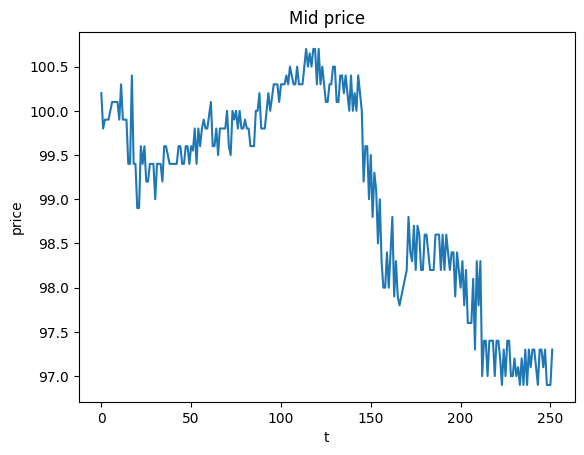

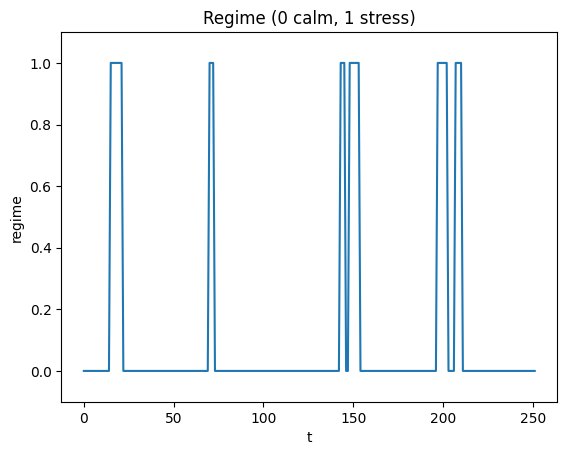

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["t"], df["price"])
plt.title("Mid price")
plt.xlabel("t")
plt.ylabel("price")
plt.show()

plt.figure()
plt.plot(df["t"], df["regime"])
plt.title("Regime (0 calm, 1 stress)")
plt.xlabel("t")
plt.ylabel("regime")
plt.ylim(-0.1, 1.1)
plt.show()


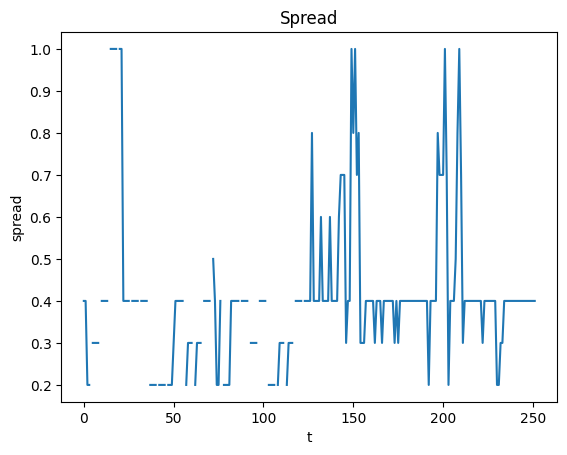

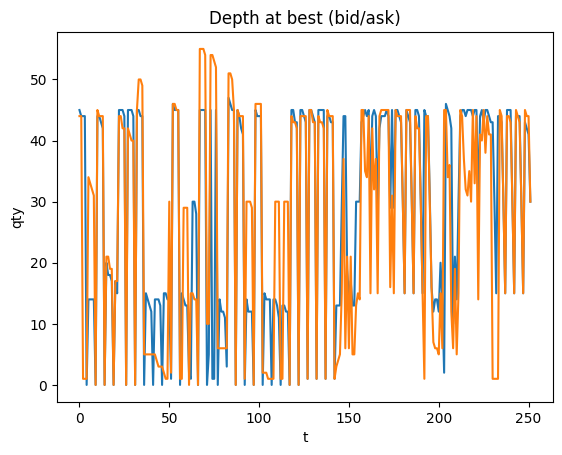

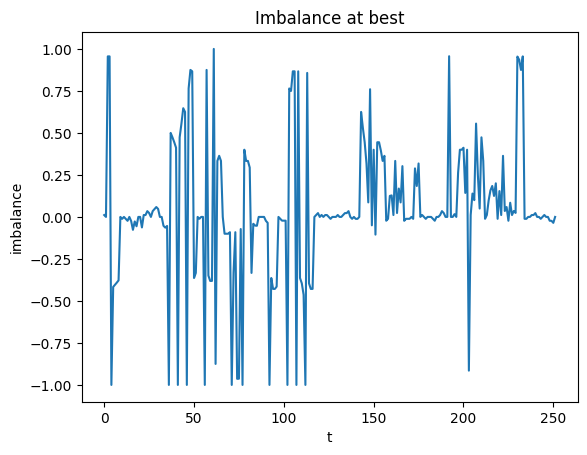

In [20]:
plt.figure()
plt.plot(df["t"], df["spread"])
plt.title("Spread")
plt.xlabel("t")
plt.ylabel("spread")
plt.show()

plt.figure()
plt.plot(df["t"], df["depth_bid"])
plt.plot(df["t"], df["depth_ask"])
plt.title("Depth at best (bid/ask)")
plt.xlabel("t")
plt.ylabel("qty")
plt.show()

plt.figure()
plt.plot(df["t"], df["imb"])
plt.title("Imbalance at best")
plt.xlabel("t")
plt.ylabel("imbalance")
plt.show()


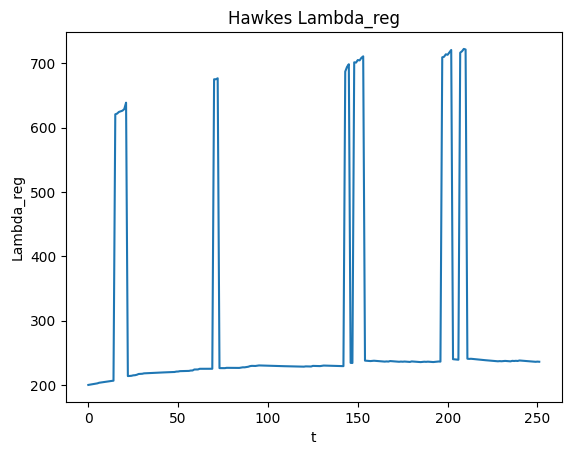

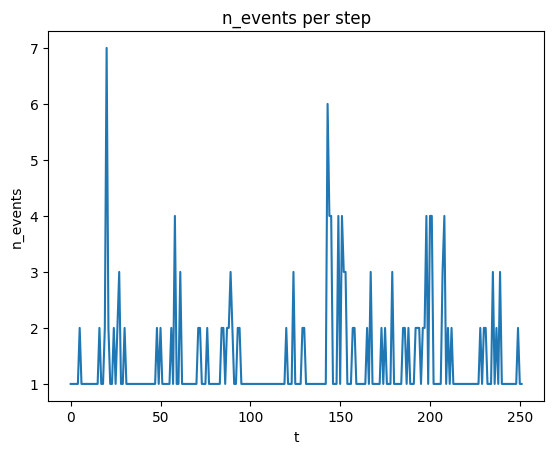

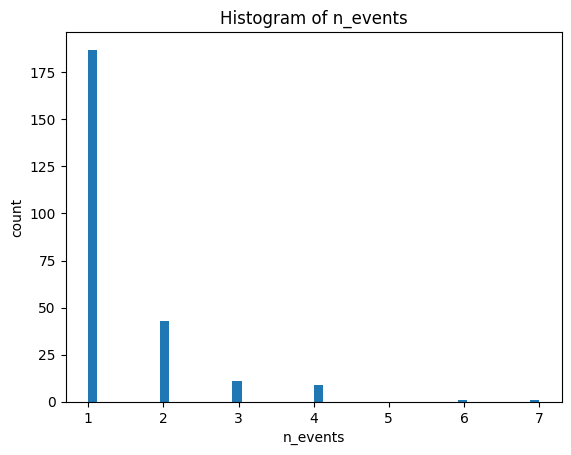

In [21]:
plt.figure()
plt.plot(df["t"], df["Lambda_reg"])
plt.title("Hawkes Lambda_reg")
plt.xlabel("t")
plt.ylabel("Lambda_reg")
plt.show()

plt.figure()
plt.plot(df["t"], df["n_events"])
plt.title("n_events per step")
plt.xlabel("t")
plt.ylabel("n_events")
plt.show()

plt.figure()
plt.hist(df["n_events"].values, bins=50)
plt.title("Histogram of n_events")
plt.xlabel("n_events")
plt.ylabel("count")
plt.show()


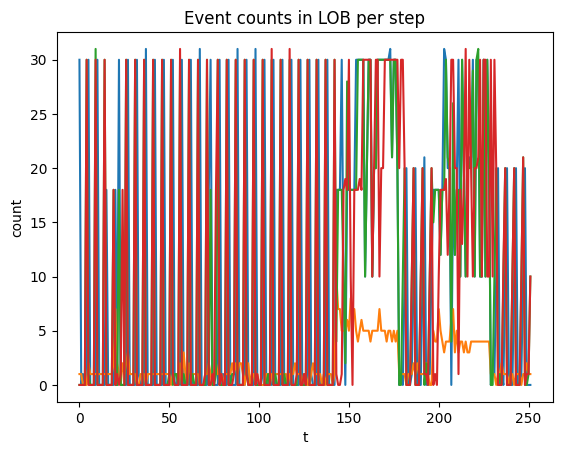

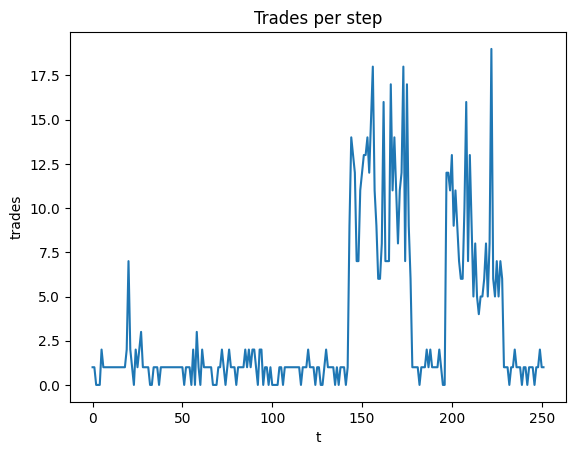

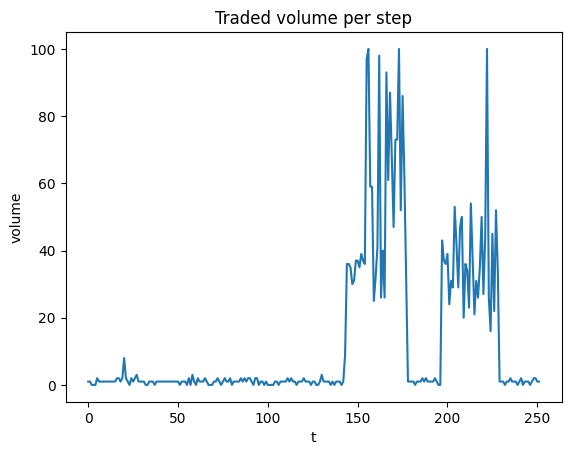

In [22]:
plt.figure()
plt.plot(df["t"], df["n_limit"])
plt.plot(df["t"], df["n_market"])
plt.plot(df["t"], df["n_cancel"])
plt.plot(df["t"], df["n_expire"])
plt.title("Event counts in LOB per step")
plt.xlabel("t")
plt.ylabel("count")
plt.show()

plt.figure()
plt.plot(df["t"], df["trades"])
plt.title("Trades per step")
plt.xlabel("t")
plt.ylabel("trades")
plt.show()

plt.figure()
plt.plot(df["t"], df["vol"])
plt.title("Traded volume per step")
plt.xlabel("t")
plt.ylabel("volume")
plt.show()


In [12]:
def show_snapshot(i):
    t, mid, bids, asks = m.l2_snapshots[i]
    print("snapshot", i, "t", t, "mid", mid)
    print("BIDS (ticks, qty):", bids)
    print("ASKS (ticks, qty):", asks)

len(m.l2_snapshots), m.l2_snapshots[0][0] if m.l2_snapshots else None
show_snapshot(0)
show_snapshot(1)
show_snapshot(2)


snapshot 0 t 25 mid 100.30000000000001
BIDS (ticks, qty): [(1001, 3.0)]
ASKS (ticks, qty): [(1004, 4.0), (1006, 1.0)]
snapshot 1 t 50 mid 100.2
BIDS (ticks, qty): [(1002, 12.0), (1001, 37.0), (1000, 19.0), (999, 13.0), (998, 9.0), (997, 6.0)]
ASKS (ticks, qty): [(1005, 30.0), (1006, 29.0), (1007, 17.0), (1008, 11.0), (1009, 9.0), (1010, 3.0)]
snapshot 2 t 75 mid 101.60000000000001
BIDS (ticks, qty): [(1016, 6.0), (1015, 3.0), (1014, 2.0), (1013, 14.0), (1012, 6.0), (1011, 4.0)]
ASKS (ticks, qty): [(1022, 3.0), (1023, 14.0), (1024, 6.0), (1025, 4.0), (1026, 7.0), (1027, 3.0), (1028, 2.0)]


In [3]:
alphas = [0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
out = []
for a in alphas:
    _, _, s = run_h1_pricing_experiment(
        cfg=cfg, dt=dt, steps=steps, r=r, K_grid=K_grid,
        option_type="put", alpha_frac=a,
        n_paths=200, n_mc=40000, n_rep=10, seed0=1
    )
    out.append((a, s["mean_abs_err_bs"], s["mean_abs_err_frac"]))
out


t= 200 bb/ba/sp= 104.10000000000001 104.5 0.3999999999999915 depth= 43.0 45.0 trades_step= 1
t= 200 bb/ba/sp= 104.80000000000001 105.10000000000001 0.29999999999999716 depth= 15.0 30.0 trades_step= 19
t= 200 bb/ba/sp= 74.9 75.10000000000001 0.20000000000000284 depth= 30.0 13.0 trades_step= 7
t= 200 bb/ba/sp= 108.9 109.9 1.0 depth= 14.0 11.0 trades_step= 3
t= 200 bb/ba/sp= 111.4 111.80000000000001 0.4000000000000057 depth= 44.0 45.0 trades_step= 1
t= 200 bb/ba/sp= 110.4 110.60000000000001 0.20000000000000284 depth= 15.0 32.0 trades_step= 5
t= 200 bb/ba/sp= 89.0 89.2 0.20000000000000284 depth= 14.0 29.0 trades_step= 7
t= 200 bb/ba/sp= 100.9 101.5 0.5999999999999943 depth= 4.0 1.0 trades_step= 2
t= 200 bb/ba/sp= 103.0 103.2 0.20000000000000284 depth= 14.0 2.0 trades_step= 0
t= 200 bb/ba/sp= 94.30000000000001 94.7 0.3999999999999915 depth= 14.0 15.0 trades_step= 8
t= 200 bb/ba/sp= 103.0 104.0 1.0 depth= 19.0 17.0 trades_step= 1
t= 200 bb/ba/sp= 113.2 113.4 0.20000000000000284 depth= 5.0 14

[(0.2, 0.47592830265062663, 0.30383420983371623),
 (0.3, 0.47592830265062663, 0.2712644787341912),
 (0.5, 0.47592830265062663, 0.25317780186183747),
 (0.6, 0.47592830265062663, 0.2664873204485118),
 (0.7, 0.47592830265062663, 0.29834509376486157),
 (0.8, 0.47592830265062663, 0.3487327181859104),
 (0.9, 0.47592830265062663, 0.4076583325847217)]

In [4]:
from analysis import run_abm_paths, estimate_sigma
paths = run_abm_paths(cfg, n_paths=50, seed0=1)
sigma = estimate_sigma(paths, dt=cfg["dt"])
sigma


t= 200 bb/ba/sp= 104.10000000000001 104.5 0.3999999999999915 depth= 43.0 45.0 trades_step= 1
t= 200 bb/ba/sp= 104.80000000000001 105.10000000000001 0.29999999999999716 depth= 15.0 30.0 trades_step= 19
t= 200 bb/ba/sp= 74.9 75.10000000000001 0.20000000000000284 depth= 30.0 13.0 trades_step= 7
t= 200 bb/ba/sp= 108.9 109.9 1.0 depth= 14.0 11.0 trades_step= 3
t= 200 bb/ba/sp= 111.4 111.80000000000001 0.4000000000000057 depth= 44.0 45.0 trades_step= 1
t= 200 bb/ba/sp= 110.4 110.60000000000001 0.20000000000000284 depth= 15.0 32.0 trades_step= 5
t= 200 bb/ba/sp= 89.0 89.2 0.20000000000000284 depth= 14.0 29.0 trades_step= 7
t= 200 bb/ba/sp= 100.9 101.5 0.5999999999999943 depth= 4.0 1.0 trades_step= 2
t= 200 bb/ba/sp= 103.0 103.2 0.20000000000000284 depth= 14.0 2.0 trades_step= 0
t= 200 bb/ba/sp= 94.30000000000001 94.7 0.3999999999999915 depth= 14.0 15.0 trades_step= 8
t= 200 bb/ba/sp= 103.0 104.0 1.0 depth= 19.0 17.0 trades_step= 1
t= 200 bb/ba/sp= 113.2 113.4 0.20000000000000284 depth= 5.0 14

0.06892426359532199

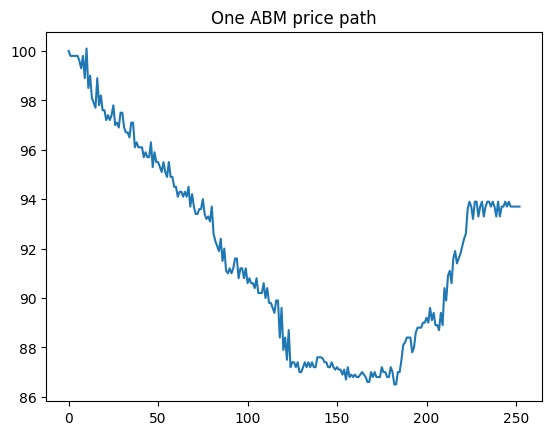

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(paths[6])
plt.title("One ABM price path")
plt.show()


In [9]:
from visualization import plot_market_dashboard

plot_market_dashboard(cfg, paths[0], dt=cfg["dt"])

TypeError: plot_market_dashboard() got an unexpected keyword argument 'dt'